# Load and save DataFrames

We do not cover all features of the packages. Please refer to their documentation to learn them.

- https://github.com/ExpandingMan/Arrow.jl
- https://github.com/invenia/JLSO.jl
- https://github.com/JuliaData/JSONTables.jl
- https://github.com/xiaodaigh/JDF.jl

Here we'll load `CSV.jl` to read and write CSV files and `Arrow.jl`, `JLSO.jl`, and serialization, which allow us to work with a binary format and `JSONTables.jl` for JSON interaction. Finally we consider a custom `JDF.jl` format.

In [1]:
using DataFrames
using Arrow
using CSV
using Serialization
using JLSO
using JSONTables
using CodecZlib
using ZipFile
using JDF
using StatsPlots ## for charts
using Mmap ## for compression

Let's create a simple `DataFrame` for testing purposes,

In [2]:
x = DataFrame(
    A=[true, false, true], B=[1, 2, missing],
    C=[missing, "b", "c"], D=['a', missing, 'c']
)

3×4 DataFrame
 Row │ A      B        C        D       
     │ Bool   Int64?   String?  Char?   
─────┼──────────────────────────────────
   1 │  true        1  missing  a
   2 │ false        2  b        missing 
   3 │  true  missing  c        c

and use `eltypes` to look at the columnwise types.

In [3]:
eltype.(eachcol(x))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, Char}

## CSV.jl
Let's use `CSV` to save `x` to disk; make sure `x1.csv` does not conflict with some file in your working directory.

In [4]:
CSV.write("x1.csv", x)

"x1.csv"

Now we can see how it was saved by reading `x.csv`.

In [5]:
print(read("x1.csv", String))

A,B,C,D
true,1,,a
false,2,b,
true,,c,c


We can also load it back as a data frame

In [6]:
y = CSV.read("x1.csv", DataFrame)

3×4 DataFrame
 Row │ A      B        C         D        
     │ Bool   Int64?   String1?  String1? 
─────┼────────────────────────────────────
   1 │  true        1  missing   a
   2 │ false        2  b         missing  
   3 │  true  missing  c         c

Note that when loading in a `DataFrame` from a `CSV` the column type for columns `:C` `:D` have changed to use special strings defined in the InlineStrings.jl package.

In [7]:
eltype.(eachcol(y))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, InlineStrings.String1}
 Union{Missing, InlineStrings.String1}

## Serialization by JDF.jl and JLSO.jl

Now we use serialization to save `x`.

There are two ways to perform serialization. The first way is to use the `Serialization.serialize` as below:

Note that in general, this process _will not work_ if the reading and writing are done by different versions of Julia, or an instance of Julia with a different system image.

In [8]:
open("x.bin", "w") do io
    serialize(io, x)
end

Now we load back the saved file to `y` variable. Again `y` is identical to `x`. However, please beware that if you session does not have DataFrames.jl loaded, then it may not recognize the content as DataFrames.jl

In [9]:
y = open(deserialize, "x.bin")

3×4 DataFrame
 Row │ A      B        C        D       
     │ Bool   Int64?   String?  Char?   
─────┼──────────────────────────────────
   1 │  true        1  missing  a
   2 │ false        2  b        missing 
   3 │  true  missing  c        c

In [10]:
eltype.(eachcol(y))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, Char}

### JDF.jl
`JDF.jl` is a relatively new package designed to serialize DataFrames. You can save a DataFrame with the `savejdf` function.
For more details about design assumptions and limitations of `JDF.jl` please check out https://github.com/xiaodaigh/JDF.jl.

In [11]:
JDF.save("x.jdf", x);

To load the saved JDF file, one can use the `loadjdf` function

In [12]:
x_loaded = JDF.load("x.jdf") |> DataFrame

3×4 DataFrame
 Row │ A      B        C        D       
     │ Bool   Int64?   String?  Char?   
─────┼──────────────────────────────────
   1 │  true        1  missing  a
   2 │ false        2  b        missing 
   3 │  true  missing  c        c

You can see that they are the same

In [13]:
isequal(x_loaded, x)

true

JDF.jl offers the ability to load only certain columns from disk to help with working with large files.
set up a JDFFile which is a on disk representation of `x` backed by JDF.jl

In [14]:
x_ondisk = jdf"x.jdf"

JDF.JDFFile{String}("x.jdf")

We can see all the names of `x` without loading it into memory

In [15]:
names(x_ondisk)

4-element Vector{Symbol}:
 :A
 :B
 :C
 :D

The below is an example of how to load only columns `:A` and `:D`

In [16]:
xd = JDF.load(x_ondisk; cols=["A", "D"]) |> DataFrame

3×2 DataFrame
 Row │ A      D       
     │ Bool   Char?   
─────┼────────────────
   1 │  true  a
   2 │ false  missing 
   3 │  true  c

### JLSO.jl
Another way to perform serialization is by using the [JLSO.jl](https://github.com/invenia/JLSO.jl) library:

In [17]:
JLSO.save("x.jlso", :data => x)

Now we can load back the file to `y`

In [18]:
y = JLSO.load("x.jlso")[:data]

3×4 DataFrame
 Row │ A      B        C        D       
     │ Bool   Int64?   String?  Char?   
─────┼──────────────────────────────────
   1 │  true        1  missing  a
   2 │ false        2  b        missing 
   3 │  true  missing  c        c

In [19]:
eltype.(eachcol(y))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, Char}

## JSONTables.jl
Often you might need to read and write data stored in JSON format. JSONTables.jl provides a way to process them in row-oriented or column-oriented layout. We present both options below.

In [20]:
open(io -> arraytable(io, x), "x1.json", "w")

106

In [21]:
open(io -> objecttable(io, x), "x2.json", "w")

76

In [22]:
print(read("x1.json", String))

[{"A":true,"B":1,"C":null,"D":"a"},{"A":false,"B":2,"C":"b","D":null},{"A":true,"B":null,"C":"c","D":"c"}]

In [23]:
print(read("x2.json", String))

{"A":[true,false,true],"B":[1,2,null],"C":[null,"b","c"],"D":["a",null,"c"]}

In [24]:
y1 = open(jsontable, "x1.json") |> DataFrame

3×4 DataFrame
 Row │ A      B        C        D       
     │ Bool   Int64?   String?  String? 
─────┼──────────────────────────────────
   1 │  true        1  missing  a
   2 │ false        2  b        missing 
   3 │  true  missing  c        c

In [25]:
eltype.(eachcol(y1))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, String}

In [26]:
y2 = open(jsontable, "x2.json") |> DataFrame

3×4 DataFrame
 Row │ A      B        C        D       
     │ Bool   Int64?   String?  String? 
─────┼──────────────────────────────────
   1 │  true        1  missing  a
   2 │ false        2  b        missing 
   3 │  true  missing  c        c

In [27]:
eltype.(eachcol(y2))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, String}

## Arrow.jl
Finally we use Apache Arrow format that allows, in particular, for data interchange with R or Python.

In [28]:
Arrow.write("x.arrow", x)

"x.arrow"

In [29]:
y = Arrow.Table("x.arrow") |> DataFrame

3×4 DataFrame
 Row │ A      B        C        D       
     │ Bool   Int64?   String?  Char?   
─────┼──────────────────────────────────
   1 │  true        1  missing  a
   2 │ false        2  b        missing 
   3 │  true  missing  c        c

In [30]:
eltype.(eachcol(y))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, Char}

Note that columns of `y` are immutable

In [31]:
try
    y.A[1] = false
catch e
    show(e)
end

ReadOnlyMemoryError()

This is because `Arrow.Table` uses memory mapping and thus uses a custom vector types:

In [32]:
y.A

3-element Arrow.BoolVector{Bool}:
 1
 0
 1

In [33]:
y.B

3-element Arrow.Primitive{Union{Missing, Int64}, Vector{Int64}}:
 1
 2
  missing

You can get standard Julia Base vectors by copying a data frame

In [34]:
y2 = copy(y)

3×4 DataFrame
 Row │ A      B        C        D       
     │ Bool   Int64?   String?  Char?   
─────┼──────────────────────────────────
   1 │  true        1  missing  a
   2 │ false        2  b        missing 
   3 │  true  missing  c        c

In [35]:
y2.A

3-element Vector{Bool}:
 1
 0
 1

In [36]:
y2.B

3-element Vector{Union{Missing, Int64}}:
 1
 2
  missing

## Basic benchmarking
Next, we'll create some files, so be careful that you don't already have these files in your working directory!
In particular, we'll time how long it takes us to write a `DataFrame` with 1000 rows and 100000 columns.

In [37]:
bigdf = DataFrame(rand(Bool, 10^4, 1000), :auto)

bigdf[!, 1] = Int.(bigdf[!, 1])
bigdf[!, 2] = bigdf[!, 2] .+ 0.5
bigdf[!, 3] = string.(bigdf[!, 3], ", as string")

println("First run")

First run


In [38]:
println("CSV.jl")
csvwrite1 = @elapsed @time CSV.write("bigdf1.csv", bigdf)
println("Serialization")
serializewrite1 = @elapsed @time open(io -> serialize(io, bigdf), "bigdf.bin", "w")
println("JDF.jl")
jdfwrite1 = @elapsed @time JDF.save("bigdf.jdf", bigdf)
println("JLSO.jl")
jlsowrite1 = @elapsed @time JLSO.save("bigdf.jlso", :data => bigdf)
println("Arrow.jl")
arrowwrite1 = @elapsed @time Arrow.write("bigdf.arrow", bigdf)
println("JSONTables.jl arraytable")
jsontablesawrite1 = @elapsed @time open(io -> arraytable(io, bigdf), "bigdf1.json", "w")
println("JSONTables.jl objecttable")
jsontablesowrite1 = @elapsed @time open(io -> objecttable(io, bigdf), "bigdf2.json", "w")
println("Second run")
println("CSV.jl")
csvwrite2 = @elapsed @time CSV.write("bigdf1.csv", bigdf)
println("Serialization")
serializewrite2 = @elapsed @time open(io -> serialize(io, bigdf), "bigdf.bin", "w")
println("JDF.jl")
jdfwrite2 = @elapsed @time JDF.save("bigdf.jdf", bigdf)
println("JLSO.jl")
jlsowrite2 = @elapsed @time JLSO.save("bigdf.jlso", :data => bigdf)
println("Arrow.jl")
arrowwrite2 = @elapsed @time Arrow.write("bigdf.arrow", bigdf)
println("JSONTables.jl arraytable")
jsontablesawrite2 = @elapsed @time open(io -> arraytable(io, bigdf), "bigdf1.json", "w")
println("JSONTables.jl objecttable")
jsontablesowrite2 = @elapsed @time open(io -> objecttable(io, bigdf), "bigdf2.json", "w")

CSV.jl
  4.182118 seconds (44.60 M allocations: 1.126 GiB, 1.93% gc time, 70.66% compilation time)
Serialization
  0.182378 seconds (148.06 k allocations: 9.349 MiB, 25.80% compilation time)
JDF.jl
  0.167824 seconds (46.70 k allocations: 147.645 MiB, 7.71% gc time, 26.96% compilation time)
JLSO.jl
  1.042447 seconds (170.03 k allocations: 17.368 MiB, 0.58% gc time, 6.27% compilation time)
Arrow.jl
  3.306893 seconds (3.02 M allocations: 209.474 MiB, 1.39% gc time, 97.12% compilation time)
JSONTables.jl arraytable
 11.088881 seconds (229.61 M allocations: 5.423 GiB, 14.59% gc time, 0.07% compilation time)
JSONTables.jl objecttable
  0.441042 seconds (62.21 k allocations: 308.136 MiB, 47.08% gc time, 15.77% compilation time)
Second run
CSV.jl
  1.451915 seconds (44.40 M allocations: 1.113 GiB, 17.16% gc time)
Serialization
  0.142911 seconds (14.32 k allocations: 397.188 KiB, 5.72% compilation time)
JDF.jl
  0.120403 seconds (28.11 k allocations: 146.392 MiB, 8.49% gc time)
JLSO.jl
  0.

0.204651448

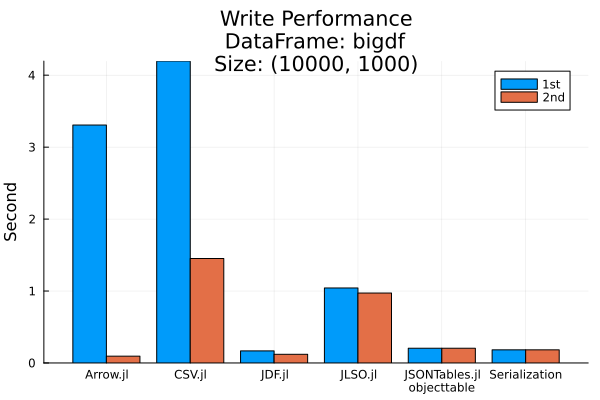

In [39]:
groupedbar(
    repeat(["CSV.jl", "Serialization", "JDF.jl", "JLSO.jl", "Arrow.jl", "JSONTables.jl\nobjecttable"],
        inner=2),
    [csvwrite1, csvwrite2, serializewrite1, serializewrite1, jdfwrite1, jdfwrite2,
        jlsowrite1, jlsowrite2, arrowwrite1, arrowwrite2, jsontablesowrite2, jsontablesowrite2],
    group=repeat(["1st", "2nd"], outer=6),
    ylab="Second",
    title="Write Performance\nDataFrame: bigdf\nSize: $(size(bigdf))"
)

In [40]:
data_files = ["bigdf1.csv", "bigdf.bin", "bigdf.arrow", "bigdf1.json", "bigdf2.json"]
df = DataFrame(file=data_files, size=getfield.(stat.(data_files), :size))
append!(df, DataFrame(file="bigdf.jdf", size=reduce((x, y) -> x + y.size,
    stat.(joinpath.("bigdf.jdf", readdir("bigdf.jdf"))),
    init=0)))
sort!(df, :size)

6×2 DataFrame
 Row │ file         size      
     │ String       Int64     
─────┼────────────────────────
   1 │ bigdf.arrow    1742874
   2 │ bigdf.bin      5197783
   3 │ bigdf.jdf      5220906
   4 │ bigdf1.csv    55088279
   5 │ bigdf2.json   55092280
   6 │ bigdf1.json  124033387

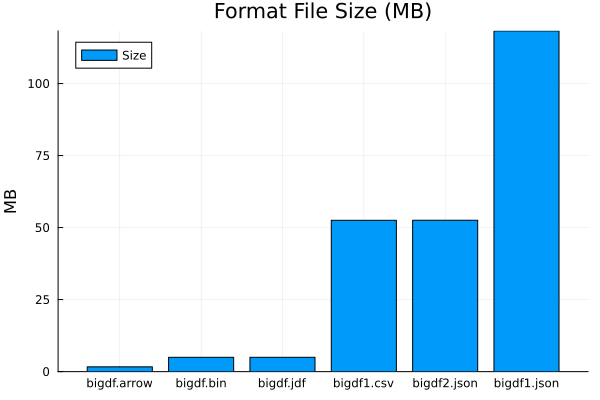

In [41]:
@df df plot(:file, :size / 1024^2, seriestype=:bar, title="Format File Size (MB)", label="Size", ylab="MB")

In [42]:
println("First run")
println("CSV.jl")
csvread1 = @elapsed @time CSV.read("bigdf1.csv", DataFrame)
println("Serialization")
serializeread1 = @elapsed @time open(deserialize, "bigdf.bin")
println("JDF.jl")
jdfread1 = @elapsed @time JDF.load("bigdf.jdf") |> DataFrame
println("JLSO.jl")
jlsoread1 = @elapsed @time JLSO.load("bigdf.jlso")
println("Arrow.jl")
arrowread1 = @elapsed @time df_tmp = Arrow.Table("bigdf.arrow") |> DataFrame
arrowread1copy = @elapsed @time copy(df_tmp)
println("JSONTables.jl arraytable")
jsontablesaread1 = @elapsed @time open(jsontable, "bigdf1.json")
println("JSONTables.jl objecttable")
jsontablesoread1 = @elapsed @time open(jsontable, "bigdf2.json")
println("Second run")
csvread2 = @elapsed @time CSV.read("bigdf1.csv", DataFrame)
println("Serialization")
serializeread2 = @elapsed @time open(deserialize, "bigdf.bin")
println("JDF.jl")
jdfread2 = @elapsed @time JDF.load("bigdf.jdf") |> DataFrame
println("JLSO.jl")
jlsoread2 = @elapsed @time JLSO.load("bigdf.jlso")
println("Arrow.jl")
arrowread2 = @elapsed @time df_tmp = Arrow.Table("bigdf.arrow") |> DataFrame
arrowread2copy = @elapsed @time copy(df_tmp)
println("JSONTables.jl arraytable")
jsontablesaread2 = @elapsed @time open(jsontable, "bigdf1.json")
println("JSONTables.jl objecttable")
jsontablesoread2 = @elapsed @time open(jsontable, "bigdf2.json");

First run
CSV.jl
  1.118292 seconds (397.72 k allocations: 51.661 MiB, 1.84% gc time, 35.97% compilation time)
Serialization
  0.421860 seconds (9.49 M allocations: 155.129 MiB, 6.02% gc time, 6.04% compilation time)
JDF.jl
  0.235720 seconds (123.90 k allocations: 161.540 MiB, 69.39% compilation time)
JLSO.jl
  0.358017 seconds (9.50 M allocations: 157.744 MiB, 2.95% gc time, 6.18% compilation time)
Arrow.jl
  0.373816 seconds (347.63 k allocations: 22.531 MiB, 98.14% compilation time)
  0.054821 seconds (12.50 k allocations: 10.320 MiB)
JSONTables.jl arraytable
 13.365779 seconds (30.24 M allocations: 2.530 GiB, 4.82% gc time)
JSONTables.jl objecttable
  0.346682 seconds (7.05 k allocations: 282.608 MiB, 2.31% gc time, 0.04% compilation time)
Second run
  0.829712 seconds (137.55 k allocations: 34.245 MiB)
Serialization
  0.384698 seconds (9.48 M allocations: 154.650 MiB, 4.71% gc time)
JDF.jl
  0.060879 seconds (69.69 k allocations: 157.941 MiB)
JLSO.jl
  0.371550 seconds (9.50 M al

Exclude JSONTables due to much longer timing

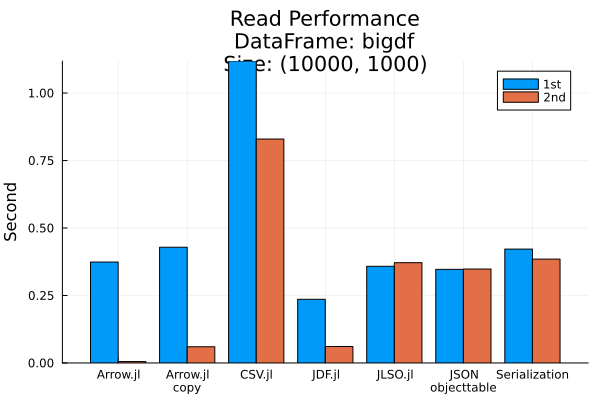

In [43]:
groupedbar(
    repeat(["CSV.jl", "Serialization", "JDF.jl", "JLSO.jl", "Arrow.jl", "Arrow.jl\ncopy", ##"JSON\narraytable",
            "JSON\nobjecttable"], inner=2),
    [csvread1, csvread2, serializeread1, serializeread2, jdfread1, jdfread2, jlsoread1, jlsoread2,
        arrowread1, arrowread2, arrowread1 + arrowread1copy, arrowread2 + arrowread2copy,
        # jsontablesaread1, jsontablesaread2,
        jsontablesoread1, jsontablesoread2],
    group=repeat(["1st", "2nd"], outer=7),
    ylab="Second",
    title="Read Performance\nDataFrame: bigdf\nSize: $(size(bigdf))"
)

## Using gzip compression
A common user requirement is to be able to load and save CSV that are compressed using gzip. Below we show how this can be accomplished using `CodecZlib.jl`. The same pattern is applicable to `JSONTables.jl` compression/decompression.
Again make sure that you do not have file named `df_compress_test.csv.gz` in your working directory.
We first generate a random data frame.

In [44]:
df = DataFrame(rand(1:10, 10, 1000), :auto)

10×1000 DataFrame
 Row │ x1     x2     x3     x4     x5     x6     x7     x8     x9     x10    x ⋯
     │ Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  I ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     2     10      9      3      4      2      6      4     10      7    ⋯
   2 │     4      2      1     10      1      8      9      5      6     10
   3 │     2      4      1      5      8      7      2      7      8      5
   4 │     7      5      4      3      9      2     10      6      6      4
   5 │     9      5      5      6      9      8      1     10      1      8    ⋯
   6 │     1     10      4      9      8      3      9      4      2      7
   7 │     2      4      2      9      7      5      7      5     10      3
   8 │     7     10      7      6      5      1      4      7     10      2
   9 │     4      7      9      3      9      5      1      5      4      5    ⋯
  10 │     8      4      7     10      7      3      5      6      2      3
                                                             990 columns omitted

GzipCompressorStream comes from `CodecZlib`

In [45]:
open("df_compress_test.csv.gz", "w") do io
    stream = GzipCompressorStream(io)
    CSV.write(stream, df)
    close(stream)
end

In [46]:
df2 = CSV.File(transcode(GzipDecompressor, Mmap.mmap("df_compress_test.csv.gz"))) |> DataFrame

10×1000 DataFrame
 Row │ x1     x2     x3     x4     x5     x6     x7     x8     x9     x10    x ⋯
     │ Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  I ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     2     10      9      3      4      2      6      4     10      7    ⋯
   2 │     4      2      1     10      1      8      9      5      6     10
   3 │     2      4      1      5      8      7      2      7      8      5
   4 │     7      5      4      3      9      2     10      6      6      4
   5 │     9      5      5      6      9      8      1     10      1      8    ⋯
   6 │     1     10      4      9      8      3      9      4      2      7
   7 │     2      4      2      9      7      5      7      5     10      3
   8 │     7     10      7      6      5      1      4      7     10      2
   9 │     4      7      9      3      9      5      1      5      4      5    ⋯
  10 │     8      4      7     10      7      3      5      6      2      3
                                                             990 columns omitted

In [47]:
df == df2

true

## Using zip files
Sometimes you may have files compressed inside a zip file.
In such a situation you may use [ZipFile.jl](https://github.com/fhs/ZipFile.jl) in conjunction an an appropriate reader to read the files.
Here we first create a ZIP file and then read back its contents into a `DataFrame`.

In [48]:
df1 = DataFrame(rand(1:10, 3, 4), :auto)

3×4 DataFrame
 Row │ x1     x2     x3     x4    
     │ Int64  Int64  Int64  Int64 
─────┼────────────────────────────
   1 │     6      5      9      6
   2 │     9      3     10      5
   3 │     6      3      1      6

In [49]:
df2 = DataFrame(rand(1:10, 3, 4), :auto)

3×4 DataFrame
 Row │ x1     x2     x3     x4    
     │ Int64  Int64  Int64  Int64 
─────┼────────────────────────────
   1 │     3      8      7      2
   2 │     3      5      3      9
   3 │     4      2      9      5

And we show yet another way to write a `DataFrame` into a CSV file:
Writing a CSV file into the zip file

In [50]:
w = ZipFile.Writer("x.zip")

f1 = ZipFile.addfile(w, "x1.csv")
write(f1, sprint(show, "text/csv", df1))

# write a second CSV file into zip file
f2 = ZipFile.addfile(w, "x2.csv", method=ZipFile.Deflate)
write(f2, sprint(show, "text/csv", df2))

close(w)

Now we read the compressed CSV file we have written:

In [51]:
z = ZipFile.Reader("x.zip");
# find the index index of file called x1.csv
index_xcsv = findfirst(x -> x.name == "x1.csv", z.files)
# to read the x1.csv file in the zip file
df1_2 = CSV.read(read(z.files[index_xcsv]), DataFrame)

3×4 DataFrame
 Row │ x1     x2     x3     x4    
     │ Int64  Int64  Int64  Int64 
─────┼────────────────────────────
   1 │     6      5      9      6
   2 │     9      3     10      5
   3 │     6      3      1      6

In [52]:
df1_2 == df1

true

In [53]:
# find the index index of file called x2.csv
index_xcsv = findfirst(x -> x.name == "x2.csv", z.files)
# to read the x2.csv file in the zip file
df2_2 = CSV.read(read(z.files[index_xcsv]), DataFrame)

3×4 DataFrame
 Row │ x1     x2     x3     x4    
     │ Int64  Int64  Int64  Int64 
─────┼────────────────────────────
   1 │     3      8      7      2
   2 │     3      5      3      9
   3 │     4      2      9      5

In [54]:
df2_2 == df2

true

Note that once you read a given file from `z` object its stream is all used-up (reaching its end). Therefore to read it again you need to close the file object `z` and open it again.
Also do not forget to close the zip file once you are done.

In [55]:
close(z)

Remove generated files

In [56]:
rm("x.arrow")
rm("x.bin")
rm("x.zip")
rm("x.jlso")
rm("x1.csv")
rm("x1.json")
rm("x2.json")
rm("x.jdf", recursive=true)
rm("bigdf.jdf", recursive=true)
rm("df_compress_test.csv.gz")
rm("bigdf1.json")
rm("bigdf1.csv")
rm("bigdf2.json")
rm("bigdf.jlso")
rm("bigdf.bin")
rm("bigdf.arrow")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*